Data Science + Social Justice<br>
TF-IDF <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

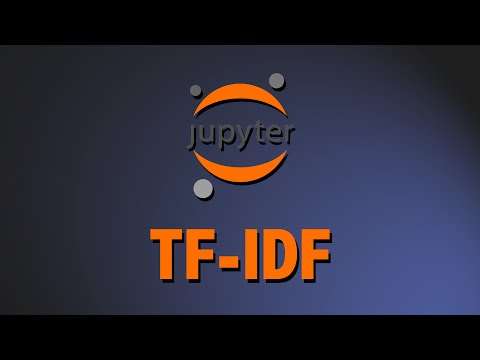

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('Bf5gBRs_xZQ', width=640, height=360)

# TF-IDF

This notebook introduces TF-IDF, which allows us to compare different subsets of our subreddit. 

**After completing this notebook, you will be able to:**
1. Understand how tf-idf can be used to compare (subsets of) datasets;
2. Find most-distinctive words in a subreddit using tf-idf;
3. Find similar posts using tf-idf.

There are several basic programming exercises scattered throughout for those who need it.


## Retrieving the dataset
Let's get the data. Make sure you're in the "Data" directory when importing by running the magic command `%pwd`.
If you're not in the right directory, use `os.chdir` to navigate there.

In [1]:
%pwd

'/Users/tomvannuenen/Downloads/DIGHUM160/Notebooks/Week 2'

In [5]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir('../../Data')

FileNotFoundError: [Errno 2] No such file or directory: '../../Data'

Importing 

In [44]:
import pandas as pd

df = pd.read_csv('aita_sub_top_sm_lemmas.csv')

In [45]:
df.head(3)

,idint,idstr,created,nsfw,author,title,selftext,lemmas,score,distinguish,textlen,num_comments,flair_text,flair_css_class
0,427576402,t3_72kg2a,1506433689,0.0,Ritsku,AITA for breaking up with my girlfriend becaus...,My girlfriend recently went to the beach with ...,girlfriend recently beach friend tiny bikini b...,679.0,NaN,4917.0,434.0,no a--holes here,NaN
1,551887974,t3_94kvhi,1533404095,0.0,hhhhhhffff678,AITA for banning smoking in my house and telli...,My parents smoke like chimneys. I used to as w...,parent smoke like chimney use quit wife young ...,832.0,NaN,2076.0,357.0,asshole,ass
2,552654542,t3_951az2,1533562299,0.0,creepatthepool,AITA? Creep wears skimpy bathing suit to pool,Hi guys. Throwaway for obv reasons.\n\nI'm a f...,hi guy throwaway obv reason i'm female child b...,23.0,NaN,1741.0,335.0,Shitpost,NaN


## Implementing TF_IDF
TF-IDF, short for *term frequency–inverse document frequency*, is a numerical statistic that reflects how important a word is to a document in a collection or corpus.
TF-IDF is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The TF-IDF value increases proportionally to the number of times a word appears in the document (the term frequency, or TF), and is offset by the number of documents in the corpus that contain the word (the inverse document frequency, or IDF). This helps to adjust for the fact that some words appear more frequently in general – such as articles and prepositions.

Terms with high tfidf values for a given document are generally the most descriptive of that document. If a word occurs many times in one post but rarely in the rest of the corpus, it is probably useful for characterizing that post; conversely, if a word occurs frequently in a post but also occurs frequently in the corpus, it is probably less characteristic of that post.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
  'My cat has paws.',
  'Can we let the dog out?',
  'Our dog really likes the cat but the cat does not agree.']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
#vectorizer.get_feature_names_out()
X.toarray()


array([[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 2, 0]])

Each column in the matrix represents a unique word in the vocabulary, while each row represents the document in our dataset. In this case, we only have one book title (i.e. the document), and therefore we have only 1 row. The values in each cell are the word counts. Note that with this representation, counts of some words could be 0 if the word did not appear in the corresponding document.

Let's show the resulting vocabulary. Note that the numbers are not counts, they are the position in the sparse vector.


In [129]:
vectorizer.vocabulary_

{'my': 9,
 'cat': 3,
 'has': 6,
 'paws': 13,
 'can': 2,
 'we': 16,
 'let': 7,
 'the': 15,
 'dog': 5,
 'out': 12,
 'our': 11,
 'really': 14,
 'like': 8,
 'but': 1,
 'does': 4,
 'not': 10,
 'agree': 0}

Lets see how many docs and unique words we have.

In [130]:
X.shape

(3, 17)

Sparse matrices are the simplest way to represent texts. However, it biases most frequent words and ends up ignoring rare words which could have helped is in processing our data more efficiently.

Oftentimes we not only want to focus on the frequency of words present in the corpus but also want to know the importance of the words. This is where tf-idf  (term frequency-inverse document frequency) comes in. Tf-idf is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics: how many times a word appears in a document, and the *inverse document frequency* of the word across a set of documents. For the latter, we divide the total number of documents by the number of documents containing the term, and then take the logarithm of that quotient. This tells us if a word is common or rare across all documents.




### Testing tf-idf with a toy dataset

Let's try tf-idf out with a toy dataset. Here we have three documents about Python, but with different meanings.

In [11]:
document1 = """Python is a 2000 made-for-TV horror movie directed by Richard
Clabaugh. The film features several cult favorite actors, including William
Zabka of The Karate Kid fame, Wil Wheaton, Casper Van Dien, Jenny McCarthy,
Keith Coogan, Robert Englund (best known for his role as Freddy Krueger in the
A Nightmare on Elm Street series of films), Dana Barron, David Bowe, and Sean
Whalen."""

document2 = """Python, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous pythons[2] found in Africa and Asia. Currently, 7 species are
recognised.[2] A member of this genus, P. reticulatus, is among the longest
snakes known."""

document3 = """Monty Python (also collectively known as the Pythons) are a British 
surreal comedy group who created the sketch comedy television show Monty Python's 
Flying Circus, which first aired on the BBC in 1969. Forty-five episodes were made 
over four series."""

document4 = """Python is an interpreted, high-level, general-purpose programming language. 
Created by Guido van Rossum and first released in 1991, Python's design philosophy emphasizes 
code readability with its notable use of significant whitespace. Its language constructs and 
object-oriented approach aim to help programmers write clear, logical code for small and 
large-scale projects."""

document5 = """The Colt Python is a .357 Magnum caliber revolver formerly
manufactured by Colt's Manufacturing Company of Hartford, Connecticut.
It is sometimes referred to as a "Combat Magnum". It was first introduced
in 1955, the same year as Smith &amp; Wesson's M29 .44 Magnum. The now discontinued
Colt Python targeted the premium revolver market segment."""

document6 = """The Pythonidae, commonly known simply as pythons, from the Greek word python 
(πυθων), are a family of nonvenomous snakes found in Africa, Asia, and Australia. 
Among its members are some of the largest snakes in the world. Eight genera and 31
species are currently recognized."""

test_list = [document1, document2, document3, document4, document5, document6]

We're running `CountVectorizer()` again, only this time we add some parameters. Using `max_df` we can get rid of words that appear in more than 85% of the corpus, and using `stop_words` we can insert an English stopword list.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.85, stop_words='english')
word_count_vector = cv.fit_transform(test_list)
word_count_vector.toarray()

array([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
    

In [13]:
cv.vocabulary_

{'2000': 3,
 'tv': 130,
 'horror': 65,
 'movie': 90,
 'directed': 42,
 'richard': 111,
 'clabaugh': 23,
 'film': 52,
 'features': 51,
 'cult': 36,
 'favorite': 50,
 'actors': 7,
 'including': 66,
 'william': 138,
 'zabka': 143,
 'karate': 70,
 'kid': 72,
 'fame': 48,
 'wil': 137,
 'wheaton': 135,
 'casper': 21,
 'van': 132,
 'dien': 41,
 'jenny': 69,
 'mccarthy': 86,
 'keith': 71,
 'coogan': 34,
 'robert': 112,
 'englund': 46,
 'best': 17,
 'known': 73,
 'role': 113,
 'freddy': 55,
 'krueger': 74,
 'nightmare': 91,
 'elm': 44,
 'street': 126,
 'series': 118,
 'films': 53,
 'dana': 38,
 'barron': 15,
 'david': 39,
 'bowe': 18,
 'sean': 116,
 'whalen': 134,
 'greek': 59,
 'word': 139,
 'πύθων': 145,
 'πύθωνας': 146,
 'genus': 58,
 'nonvenomous': 92,
 'pythons': 103,
 'africa': 8,
 'asia': 13,
 'currently': 37,
 'species': 125,
 'recognised': 105,
 'member': 87,
 'reticulatus': 109,
 'longest': 80,
 'snakes': 124,
 'monty': 89,
 'collectively': 26,
 'british': 19,
 'surreal': 127,
 'comed

How many docs and unique words?

In [14]:
word_count_vector.shape

(6, 147)

## Using `TfidfTransformer`

Next, we need to compute the idf values. We'll call `tfidf_transformer.fit(word_count_vector)` on the word counts we computed earlier.


In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer() 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

To get a glimpse of how the IDF values look, we are going to print it by placing the idf values in a python DataFrame. The values will be sorted in ascending order.


In [16]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(), columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
known,1.336472
pythons,1.559616
greek,1.847298
nonvenomous,1.847298
created,1.847298
...,...
film,2.252763
films,2.252763
flying,2.252763
fame,2.252763


Notice that the words "python" and "in" have the lowest idf values. This is expected: these words appear in each and every document in our collection. The lower the idf value of a word, the less unique it is to any particular document.

Now that we have the idf values, we can compute the tf-idf scores for our set of documents.

In [17]:
tf_idf_vector=tfidf_transformer.transform(word_count_vector)

By invoking `tfidf_transformer.transform()` we are computing the tf-idf scores for our docs. Internally this is computing the tf * idf  multiplication where our term frequencies (in the `word_count_vector` array) are weighted by their IDF values.

Let’s print the tf-idf values of the first document to see if it makes sense. What we are doing below is, placing the tf-idf scores from the third document into a pandas data frame and sorting it in descending order of scores.

In [18]:
feature_names = cv.get_feature_names_out() 
  
#print the scores 
df = pd.DataFrame(tf_idf_vector[2].T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
comedy,0.424705
monty,0.424705
circus,0.212353
television,0.212353
surreal,0.212353
...,...
englund,0.000000
emphasizes,0.000000
elm,0.000000
discontinued,0.000000


Through tf-idf, we have found the words that are most-distinctive of `document3`.

## Using tf-idf on Reddit datasets
Time to perform tf-idf on Reddit. We could do this on a document level (more on that later), but also on a higher level. For instance, we might be interested in the words with high TF-IDF counts when comparing two subsets of a subreddit. First, let's create two dataframes to seperate the data based on whether they were classified as "assholeish" and "non-assholeish" posts by the communities. We'll put the relevant lemmatized texts into a list.

In [54]:
df_ass = df.loc[df.flair_css_class == "ass"]
df_ass.reset_index(inplace=True)
df_not = df.loc[df.flair_css_class == "not"]
df_not.reset_index(inplace=True)

In [37]:
aita_list = [' '.join(df_ass['lemmas']), ' '.join(df_not['lemmas'])]

This time, to save time, we will be using Scikit-LEARN `TfidfVectorizer`. It is a class that basically allows us to create a matrix of word counts (what we just did with `CountVectorizer`), and immediately transform them into tf-idf values. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) for the documentation.

We simply instantiate an object of the `TfidfVectorizer`. Then, we run it by applying the `fit_transform()` method to our "aita_list". 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# settings that you use for count vectorizer will go here
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, decode_error='ignore', stop_words='english',smooth_idf=True,use_idf=True)

# fit and transform the texts
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(aita_list)


Let's have a look at our first df (assholes), and see which words are typical of those posts when compared to the posts which are by non-assholes.

In [39]:
vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] # Note that 0 refers to our first df (assholes), due to zero-based indexing

# place tf-idf values in a DataFrame
df = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)[:30]


,tfidf
johanna,0.287494
sabrina,0.191663
hayleigh,0.159719
mittens,0.151733
elena,0.143747
jeremy,0.119789
gfm,0.119789
zach,0.111803
bryan,0.111803
timmy,0.103817


# 5. Using TF-IDF to find similar posts

We can also use tf-idf to work out the similarity between any pair of documents. So given one post or comment, we could see which posts or comments are most similar. This can be useful if you're trying to find other examples of a pattern you have found and want to explore further.

This time, our "documents" will not be entire subreddits, but posts/submissions within one subreddit. Let's import the submissions and run the vectorizer without the preprocessing and lemmatizing. Tf-idf will still work this way, and this way, we will be able to read our posts.

Let's run TF-IDF over the entire corpus, so each post is compared to all the others.

In [40]:
# we could even add trigrams here by adding "ngram_range=(1,3)" to params
tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_df = .70, stop_words = 'english')
word_count_vectors = tfidf_vectorizer.fit_transform([post for post in df_ass['selftext']])

We'll start by finding a post with a clear topic. Let's grab an entry in our dataframe:

In [55]:
df_ass['selftext'][7]

'It\'s 6PM on a Friday, store has hundreds of people, there are only 3 registers open and lines are ridiculously long. The self checkout has a line that wraps but its the fastest moving line so we wait about 15 minutes in line to check ourselves out.\n\nAfter we check out, a line is forming to exit the building because everyone is waiting for the walmart receipt checker to glance at their receipt.\n\nI\'m already frustrated because of the wait so I skip the line, and the checker anxiously tries to get my attention and loudly says "SIR I NEED TO CHECK YOUR RECEIPT!", I respond with a loud(because its loud in the store) "NO THANK YOU", and walk out of the building.  People start following my example.\n\nThus ensues a 15 minute fight in the car with the wife because she feels I made a scene.\n\nEDIT: Well this turned out well.'

Let's have a quick look at the tfidf scores for the words in this submission to see if these words are indeed typical for this particular submission:

In [56]:
# get a vector out
vector_tfidfvectorizer = word_count_vectors[7] # change this number if you want to pick out a different vector / text

# place tf-idf values in a pandas data frame
df = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)[:10]

,tfidf
line,0.388256
receipt,0.345678
checker,0.309109
check,0.230729
building,0.194553
loud,0.174266
store,0.158222
anxiously,0.154554
ensues,0.154554
wait,0.152997


Now let's find the top document(s). 
The fact that our documents are now in a vector space is convenient: it allows us to make use of mathematical similarity metrics.

**Cosine similarity** is one metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. Cosine similarity compensates for the effect of the different lengths of our subreddits.



In [57]:
def find_similar(word_count_vectors, index, top_n = 5):   # you can change the `top_n` parameter if you want to retrieve more similar documents
    cosine_similarities = linear_kernel(word_count_vectors[index:index+1], word_count_vectors).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

The above function finds similar words. It uses scikit-LEARN's `linear kernel`, which uses cosine similarity to find documents that are most alike.

We can now throw the resulting scores and similar posts in a list, feed that list into a DataFrame, and check out one of them to see if it works:

In [58]:
cosine = []
for index, score in find_similar(word_count_vectors, 7):
    cosine.append(
        {'cos_score': score, 
        'text': df_ass['selftext'][index]
        })
cosine_df = pd.DataFrame(cosine)
cosine_df

,cos_score,text
0,0.182479,I was in the TSA Precheck line where people ar...
1,0.159239,About 2 weeks ago I went to the drive-thru at ...
2,0.142716,Went to WalMart recently for batteries. I have...
3,0.139136,This happened today and I feel like it was jus...
4,0.123122,I (38m) stopped by a local grocery store on my...


In [59]:
cosine_df['text'][0]

'I was in the TSA Precheck line where people are generally cognizant of the regulations. Unfortunately, a woman with her 3 children somehow ended up in this line. I have no patience for people who hold up the TSA screening line. This woman had to fish out all her feeding bottles from her 3 or 4 poorly organized bags and empty them before putting her belongings through security screening. As a result, she held up the security line for a long time. I finally had it and told her she should have been aware of the rules about liquids before getting in line and should have prepared for security screening before getting in line. I suggested that she step aside and let other travelers through and my suggestion was met with a few cheers. \n\nShe seemed really embarrassed but didn’t apologize at all. After I passed the screen I mentioned to the TSA agent he should manage the queue better. When a traveler was holding up the line he needed to step in, and he failed. He apologized and I moved on. I

This post does seem comparable!